In [1]:
import os 
from pickle import dump
from pickle import load
from os import listdir
import numpy as np
from os import getcwd
import string
import numpy as np
import tensorflow as tf
import keras.backend as K
from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3 import preprocess_input
from keras_preprocessing.image import load_img
from keras_preprocessing.image import img_to_array
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.utils import plot_model
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers import LSTM, GRU
from keras.layers import Embedding
from keras.layers import Dropout
from keras.layers.merge import add
from keras.callbacks import ModelCheckpoint
from keras.callbacks import EarlyStopping
from keras.callbacks import ReduceLROnPlateau
from keras.callbacks import History    
from keras.optimizers import Adam
from keras.models import load_model
from nltk.translate.bleu_score import corpus_bleu
import sys

In [ ]:
os.chdir("/content/drive/My Drive/Image Captioning/")


In [ ]:
from os import getcwd
getcwd()

'/content/drive/My Drive/Image Captioning'

# Merge-model

## Text

In [ ]:
def load_doc(directory):
  file=open(directory,'r')
  text=file.read()
  file.close()
  return text

In [ ]:
dir='descriptions.txt'
train_dir='Flickr8k_text/Flickr_8k.trainImages.txt'

In [ ]:
text=load_doc(train_dir)

In [ ]:
def load_set(directory):
  text=load_doc(directory)
  data=list()

  for line in text.split('\n'):
    if len(line)<1:
      continue

    data.append(line.split('.')[0])

  return set(data)

In [ ]:
train_id=load_set(train_dir)

In [ ]:
def load_clean_descriptions(directory,dataset):
  file=load_doc(directory)
  des=dict()
  for line in file.split('\n'):
    seq=line.split()
    image_id,image_des=seq[0],seq[1:]
    if image_id in dataset:
      if image_id not in des:
        des[image_id]=list()
        
      des[image_id].append('startseq ' + ' '.join(image_des) + ' endseq')

  return des 

In [ ]:
example='1386251841_5f384a0fea'

In [ ]:
train_dir = load_set("Flickr8k_text/Flickr_8k.trainImages.txt")
print("Train Dataset Length:",len(train_dir))
test_dir = load_set("Flickr8k_text/Flickr_8k.testImages.txt")
print("Test Dataset Length:",len(test_dir))
dev_dir = load_set("Flickr8k_text/Flickr_8k.devImages.txt")
print("Test Dataset Length:",len(dev_dir))

train_descriptions = load_clean_descriptions(dir,train_dir)
test_descriptions = load_clean_descriptions(dir,test_dir)
dev_descriptions = load_clean_descriptions(dir,dev_dir)

Train Dataset Length: 6000
Test Dataset Length: 1000
Test Dataset Length: 1000


In [ ]:
len(train_descriptions)

6000

In [ ]:
len(test_descriptions)

1000

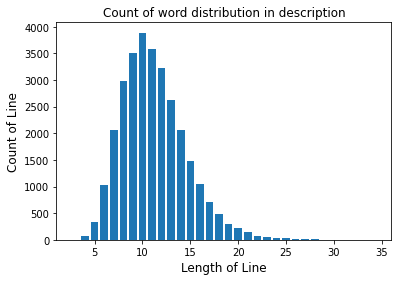

In [ ]:
import re
%matplotlib inline
import matplotlib.pyplot as plt
def plot_data(description):
  mapper=dict()
  for key, desc in description.items():
    for line in desc:
      length = len(re.findall(r'\w+', line))
      mapper[length] = mapper.get(length,0) + 1 
  plot_bar(mapper)

def plot_bar(mapper):
  plt.bar(mapper.keys(), mapper.values())
  plt.xlabel('Length of Line', fontsize=12)
  plt.ylabel('Count of Line', fontsize=12)
  plt.title('Count of word distribution in description')
  plt.show()

plot_data(train_descriptions)

In [ ]:
def to_lines(descriptions):
	all_desc = list()
	for key in descriptions.keys():
		[all_desc.append(d) for d in descriptions[key]]
	return all_desc

In [ ]:
print(to_lines(train_descriptions))

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
def to_vocabulary(description,word_count_threshold=5):
  all_captions=to_lines(description)

  word_count={}
  for line in all_captions:
    for word in line.split():
      word_count[word]=word_count.get(word,0)+1
    
  vocab=[w for w in word_count if word_count[w]>=word_count_threshold]
  return vocab

vocab=to_vocabulary(train_descriptions,5)
print("Size of Vocabulary Size : ", len(vocab))

Size of Vocabulary Size :  2530


In [ ]:
sorted(vocab)[:10]

['about',
 'above',
 'accordion',
 'acrobatic',
 'across',
 'act',
 'action',
 'adult',
 'adults',
 'advertisement']

In [ ]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

def create_tokenizer(vocab):
  tokenizer=Tokenizer(oov_token='UNK')
  tokenizer.fit_on_texts(vocab)
  return tokenizer

tokenizer=create_tokenizer(vocab)
vocab_size=len(tokenizer.word_index)+1
print('Vocab size ',vocab_size)


Vocab size  2532


In [ ]:
tokenizer.word_index['PAD0']=0



In [ ]:
wordtoix = {}
ixtoword = {}

#no word in vocab has index 0, but padding will have index 0
tokenizer.word_index['PAD0'] = 0 
wordtoix = tokenizer.word_index
for word in tokenizer.word_index:
  ixtoword[tokenizer.word_index[word]] = word

print(len(ixtoword), len(wordtoix))

2532 2532


In [ ]:
#def max_length(descriptions):
#	lines = to_lines(descriptions)
#	return max(len(d.split()) for d in lines)

In [ ]:
#max_length = max_length(train_descriptions)
#print('Description Length: %d' % max_length)

In [ ]:
def max_length(description, p):
	#lines = to_lines(descriptions)
	#return max(len(d.split()) for d in lines)
  all_desc = []
  #create a list of all desc
  for key, desc in description.items():
    [all_desc.append(line) for line in desc]
  length = list(len(line.split()) for line in all_desc)
  print('{} percentile has len of lines less than: {}'.format(p,np.percentile(length, p)))
  print('longest sentence: ', max(length))
  return int(np.percentile(length, p))

 
max_length = max_length(train_descriptions,90)
print("Max Length for training:",max_length)

90 percentile has len of lines less than: 16.0
longest sentence:  34
Max Length for training: 16


## Image text

In [ ]:
from pickle import load

def load_photo_features(directory,dataset):
  all_features=load(open(directory,'rb'))
  features={k:all_features[k] for k in dataset}
  return features


In [ ]:
dir='features.pkl'
train_features = load_photo_features(dir, train_dir)
print('Photos:',len(train_features))
test_features = load_photo_features(dir,test_dir)
print('Photos:',len(test_features))
dev_features = load_photo_features(dir,dev_dir)
print('Photos:',len(dev_features))

Photos: 6000
Photos: 1000
Photos: 1000


##**Embeding**

In [ ]:
batch_size = 32
def data_generator(descriptions, photos):
  X1, X2, y = [], [], []
  n=0
  # loop for ever over images
  while 1:
    for key, desc_list in descriptions.items():
      n+=1
      # retrieve the photo feature
      photo = photos[key]
      for desc in desc_list:
        # find the index of each word of the caption in vocabulary
        seq = tokenizer.texts_to_sequences(desc.split())
        # split one sequence into multiple X, y pairs
        # Each step of the following for loop selects one word
        # from the caption, consider that word as y and
        # all the words before that will be the X
        for i in range(1, len(seq)):
          # split into input and output pair
          in_seq, out_seq = seq[:i], seq[i] # words until i are inseq word i is outseq
          # pad input sequence
          in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
          X1.append(photo)
          X2.append(in_seq)
          y.append(out_seq)
      # yield the batch data
      if n == batch_size:
        yield ([np.array(X1), np.array(X2).squeeze(axis=-1)], np.array(y).squeeze(axis=-1))
        X1, X2, y = list(), list(), list()
        n=0

In [ ]:
generator = data_generator(train_descriptions, train_features)
inputs, outputs = next(generator)
print(inputs[0].shape)
print(inputs[1].shape)
print(outputs.shape)

(1754, 2048)
(1754, 16)
(1754,)


In [ ]:
from keras.layers import Embedding
def make_embedding_layer(embedding_dim):
  embeddings_index = {}
  file = open('glove.6B/glove.6B.100d.txt', encoding="utf-8")
  f = file.read()
  
  for line in f.split('\n'):
    if len(line)<1:
      continue
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
  file.close()
  # Get x-dim dense vector for each of the vocab_rocc
  embedding_matrix = np.zeros((vocab_size, embedding_dim)) # to import as weights for Keras Embedding layer
  for word, i in wordtoix.items():
    embedding_vector = embeddings_index.get(word,None)
    if embedding_vector is not None:
        # Words not found in the embedding index will be all zeros
      embedding_matrix[i] = embedding_vector
  print('GloVe loaded!')

  embedding_layer = Embedding(vocab_size, embedding_dim, mask_zero=True, trainable=False)
  embedding_layer.build((None,))
  embedding_layer.set_weights([embedding_matrix])
  
  return embedding_layer

In [ ]:
embedding_layer = make_embedding_layer(100)

In [ ]:
#dump(embedding_layer,open('embedding.pkl','wb'))

In [ ]:
#embedding_layer = load(open('embedding.pkl', 'rb'))

# Model

In [ ]:
def masked_loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = K.sparse_categorical_crossentropy(real, pred, from_logits= False) # sparse cat gets pred classes in 'int' form
    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask
    return tf.reduce_mean(loss_)

In [ ]:
def define_model(embedding, vocab_size, max_length):
  # feature extractor model
  inputs1 = Input(shape=(2048,))
  fe1 = Dropout(0.5)(inputs1)
  fe2 = Dense(256, activation='relu')(fe1)
  # sequence model
  inputs2 = Input(shape=(max_length,))
  #se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
  se1 = embedding(inputs2)
  se2 = Dropout(0.5)(se1)
  se3 = LSTM(256)(se2)
  #decoder model
  decoder1 = add([fe2,se3])
  decoder2 = Dense(256, activation='relu')(decoder1)
  outputs = Dense(vocab_size, activation='softmax')(decoder2)
  # tie it together [image, seq] [word]
  model = Model(inputs=[inputs1,inputs2],outputs=outputs)
  model.compile(loss=masked_loss_function, optimizer= Adam(clipvalue=3))
  model.summary()
  plot_model(model, to_file='model.png', show_layer_names=True ,show_shapes=True)
  return model

In [ ]:
model = define_model(embedding_layer, vocab_size, max_length)

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 16)]         0                                            
__________________________________________________________________________________________________
input_1 (InputLayer)            [(None, 2048)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 16, 100)      253200      input_2[0][0]                    
__________________________________________________________________________________________________
dropout (Dropout)               (None, 2048)         0           input_1[0][0]                    
_______________________________________________________________________________________

In [ ]:
history={'loss':[], 'BLEU_val':[]}

In [ ]:

my_callbacks = [
    EarlyStopping(monitor='loss', patience=2),
    ReduceLROnPlateau(monitor='loss', factor=0.9, patience=3, verbose=0, mode='auto', min_delta=0.0001, min_lr=0.000001)
    #ModelCheckpoint(filepath='model-ep{epoch:03d}-loss{loss:.3f}-val_loss{val_loss:.3f}.h5', monitor='val_loss', verbose=1, save_best_only=True, mode='min'),
    #ReduceLROnPlateau(monitor='val_accuracy', patience=2, verbose=1, factor=0.2, min_lr=1e-6),
    #keras.callbacks.TensorBoard(log_dir='./logs')
]

In [ ]:
def progressBar(value, endvalue, bar_length=20,job='Job'):
    percent = float(value) / endvalue
    arrow = '-' * int(round(percent * bar_length)-1) + '>'
    spaces = ' ' * (bar_length - len(arrow))
    sys.stdout.write("\r{0} Completion: [{1}] {2}%".format(job,arrow + spaces, int(round(percent * 100))))
    sys.stdout.flush()


In [ ]:
def generate_desc(model, photo):
  in_text = 'startseq'
  # iterate over the whole length of the sequence
  for i in range(max_length):
    # integer encode input sequence
    #seq = tokenizer.texts_to_sequences([in_text])[0]
    seq = tokenizer.texts_to_sequences(in_text.split())
    # pad input
    #seq = pad_sequences([seq], maxlen=max_length)
    photo = photo.reshape((1,2048))
    seq = pad_sequences([seq], maxlen=max_length).reshape((1,max_length))
    # predict next word
    yhat = model.predict([photo,seq], verbose=0)
    #convert probability to integer
    yhat = np.argmax(yhat)
    # map integer to word
    word = ixtoword[yhat]
    if word is None:
      break
    # append as input for generating the next word
    in_text += ' ' + word
    # stop if we predict the end of the sequence
    if word == 'endseq':
      break
  return in_text

In [ ]:
def beam_search(model, photo, wordtoix, k_beams):
  start = [wordtoix['startseq']]
  start_word = [[start,0.0]]
  while len(start_word[0][0]) < max_length:
    temp = []
    for s in start_word:
      #sequence of most probable words 
      # based on the previous steps
      sequence  = pad_sequences([s[0]], maxlen=max_length).reshape((1,max_length)) 
      preds = model.predict([photo.reshape(1,2048), sequence])
      # sort predictions based on the probability  
      # then take the last K_beams items, words with the most probs
      word_preds = np.argsort(preds[0])[-k_beams:] 
      # Getting the top <K_beams>(n) predictions and creating a 
      # new list so as to put them via the model again
      for w in word_preds:
        next_cap, prob = s[0][:], s[1]
        next_cap.append(w)
        prob += preds[0][w]
        temp.append([next_cap, prob])
    start_word = temp
    # Sorting according to the probabilities
    start_word = sorted(start_word, reverse=False, key=lambda l: l[1])
    # Getting the top words
    start_word = start_word[-k_beams:]

  start_word = start_word[-1][0]
  captions_ = [ixtoword[i] for i in start_word]
  final_caption = []
  for i in captions_:
    if i != 'endseq':
      final_caption.append(i)
    else:
      break

  final_caption = ' '.join(final_caption[1:])
  return final_caption

In [ ]:
def evaluate_model(model, description, photos, k_beams):
  actual, predicted = list(), list()
  # step over the whole set
  i=0
  for key, desc_list in description.items():
    i += 1
    progressBar(i, len(description), bar_length=20,job='Evaluating')
    if k_beams == 1:
      yhat = generate_desc(model, photos[key])
    else:
      yhat = beam_search(model, photos[key], wordtoix, k_beams=k_beams)
    # store actual and predicted
    references = [d.split() for d in desc_list]
    actual.append(references)
    predicted.append(yhat.split())
  b1 = corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0))
  b2 = corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0))
  b3 = corpus_bleu(actual, predicted, weights=(0.3, 0.3, 0.3, 0))
  b4 = corpus_bleu(actual, predicted, weights=(0.25, 0.25, 0.25, 0.25))
  print('\n')
  #score for 1-gram model
  print('BLEU-1: %f' % b1)
  #50% score calculated on 1-gram and other 50% using 2-gram
  print('BLEU-2: %f' % b2)
  #33% to each 1,2 and 3 gram
  print('BLEU-3: %f' % b3)
  # 1/4 score of each gram
  print('BLEU-4: %f' % b4)
  return [b1,b2,b3,b4]

====


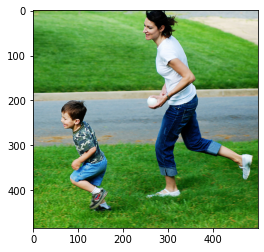

KeyboardInterrupt: ignored

In [ ]:
def test(i=5,j=20,k=50,q=850,show_pic=False):
    print('====')
    pic = list(test_features.keys())[i]
    photo = test_features[pic].reshape((1,2048))
    if show_pic:
        x=plt.imread('Flicker8k_Dataset/'+pic+'.jpg')
        plt.imshow(x)
        plt.show()
    print("Greedy:",generate_desc(model, photo))
    #print("Actual:",test_descriptions[pic][0])
    #print("Actual:",test_descriptions[pic][1])
    
    pic = list(test_features.keys())[j]
    photo = test_features[pic].reshape((1,2048))
    if show_pic:
        x=plt.imread('Flicker8k_Dataset/'+pic+'.jpg')
        plt.imshow(x)
        plt.show()
    print("Greedy:",generate_desc(model, photo))
    
    pic = list(test_features.keys())[k]
    photo = test_features[pic].reshape((1,2048))
    if show_pic:
        x=plt.imread('Flicker8k_Dataset/'+pic+'.jpg')
        plt.imshow(x)
        plt.show()
    print("Greedy:",generate_desc(model, photo))
    pic = list(test_features.keys())[q]
    photo = test_features[pic].reshape((1,2048))
    if show_pic:
        x=plt.imread('Flicker8k_Dataset/'+pic+'.jpg')
        plt.imshow(x)
        plt.show()
    print("Greedy:",generate_desc(model, photo))

    print('====')
    
    
test(show_pic=True)

In [ ]:
tf.config.run_functions_eagerly(True)

In [ ]:
# Training for more than 30 epoch may lead to overfitting
epochs = 31
batch_size = 32
steps = len(train_descriptions)//batch_size
ep = 1
for i in range(ep,epochs):
  print('Epoch :',i,'\n')
  generator = data_generator(train_descriptions, train_features)
  #fit for one epoch
  h = model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1, callbacks=my_callbacks)
  history['loss'].append(h.history['loss'])
  if i%3 == 0:
    model.save('new_model_' + str(i) + '.h5')
  
  if i%6 == 0:
    test()
    belus= evaluate_model(model, dev_descriptions, dev_features, k_beams=1)
    history['BLEU_val'].append((belus,i))
    print('\n','='*80)

dump(history,open('history.pkl','wb'))

In [ ]:
model.save_weights('weights.h5')

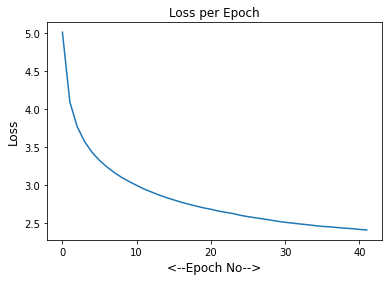

In [ ]:
y = []
y = [item for sublist in history['loss'] for item in sublist]
x = [i for i in range(len(history['loss']))]
plt.xlabel('<--Epoch No-->', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.title('Loss per Epoch')
plt.plot(x,y)

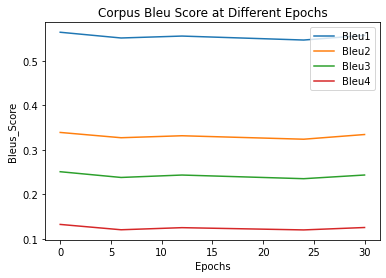

In [ ]:
y = []
y = [item for sublist in history['BLEU_val'] for item in sublist]
y = y[::2]
y1 = [item for sublist in y for item in sublist]
bleu_val1 = y1[::4]
bleu_val2 = y1[1::4]
bleu_val3 = y1[2::4]
bleu_val4 = y1[3::4]

x = [0,6,12,24,30]
plt.plot(x, bleu_val1, label = "Bleu1")
plt.plot(x, bleu_val2, label = "Bleu2")
plt.plot(x, bleu_val3, label = "Bleu3")
plt.plot(x, bleu_val4, label = "Bleu4")
plt.xlabel('Epochs')
plt.ylabel('Bleus_Score')
plt.title('Corpus Bleu Score at Different Epochs')
plt.legend()
plt.show()

In [ ]:
model = load_model('new_model_30.h5',custom_objects={'masked_loss_function':                
masked_loss_function})

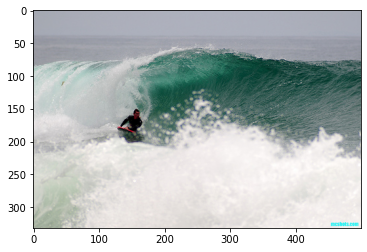

Greedy: startseq person is surfing on the waves endseq
Beam K= 3: person kayaks through rough waters


In [ ]:
pic = list(test_features.keys())[1]
feature = test_features[pic].reshape((1,2048))
x=plt.imread('Flicker8k_Dataset/'+pic+'.jpg')
plt.imshow(x)
plt.show()
print("Greedy:",generate_desc(model, feature))
print("Beam K= 3:",beam_search(model, test_features[pic], wordtoix, k_beams = 3))